In [1]:
# imports, Python SQL toolkit and Object Relational Mapper
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Connect to the SQL DB
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [3]:
#Inspect the DB

inspector = inspect(engine)
inspector.get_table_names()

# table names are measurement and station

['measurement', 'station']

In [4]:
# Print a list of column names and types for the measurement table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [5]:
# Print a list of column names and types for the station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [6]:
# Reflect the measurement and station tables into classes
# Save a reference to the classes called: Measurement and Station
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create a session
session = Session(bind=engine)

# Precipitation Analysis

In [8]:
# Perform a query to retrieve the data and precipitation scores
Precipitation_stats = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).\
    order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
Precipitation_stats_table = pd.DataFrame(Precipitation_stats, columns=['station', 'date', 'prcp', 'tobs'])
Precipitation_stats_table.head()

,station,date,prcp,tobs
0,USC00519397,2010-01-01,0.08,65.0
1,USC00513117,2010-01-01,0.28,67.0
2,USC00518838,2010-01-01,0.21,72.0
3,USC00519523,2010-01-01,0.15,75.0
4,USC00519281,2010-01-01,0.15,70.0


In [9]:
# Calculate the date 1 year ago from the last data point in the database

Most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

Year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
Year_ago

datetime.date(2016, 8, 23)

In [14]:
# Query to retrieve the last 12 months of precipitation data and plot the results
Precipitation_last_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-22').\
    order_by(Measurement.date).all()

In [20]:
# Put the last 12 months of precipitation data into dataframe with date
# Utilize the date as the index and drop null values
Precipitation_data = pd.DataFrame(Precipitation_last_year, columns=['Date', 'Precipitation (inches)'])
Precipitation_data.set_index('Date', inplace=True)
Precipitation_data = Precipitation_data.dropna()
Precipitation_data.head()

,Precipitation (inches)
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


Text(0.5, -37.97500000000004, 'Date')

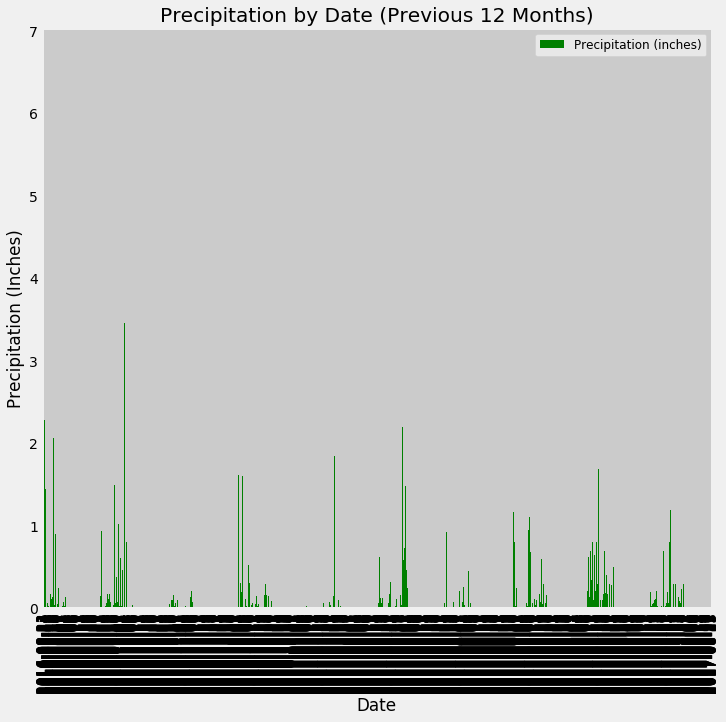

In [42]:
# Create a plot of the precipitation data for the past 12 months
color = 'green'
Precipitation_plot = Precipitation_data.plot(kind='bar', color = color, figsize=(10,10))
plt.tight_layout()
Precipitation_plot.grid(True)
plt.legend(fontsize="12")
plt.title("Precipitation by Date (Previous 12 Months)")
plt.ylabel("Precipitation (Inches)")
plt.xlabel("Date")

In [36]:
# Summary statistics for the Precipitation data
Precipitation_data.describe()

,Precipitation (inches)
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [48]:
# Show the number of observation times at each station in the dataset
session.query(func.count(Measurement.station)).group_by(Measurement.station).all()

[(1979), (2709), (2202), (2612), (1372), (511), (2772), (2724), (2669)]

In [49]:
# Query to show how many stations are available in this dataset
session.query(Station.id).count()

9

In [47]:
# List the most active stations and the counts of observations in descending order
# Station 'USC00519281' has the most observations
Station_stats = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
Station_stats

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

Temp = [Measurement.tobs,  
       func.avg(Measurement.high_temperature), 
       func.avg(Measurement.low_temperature)]
Temp_averages = session.query(*Temp).\
    filter(func.strftime("%m", Measurement.date) == "05").\
    group_by(Measurement.tobs).\
    order_by(Measurement.tobs).all()
Temp_averages


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


df = pd.DataFrame(may_averages, columns=['stock', 'open_avg', 'high_avg', 'low_avg', 'close_avg'])
df.set_index('stock', inplace=True)
df.plot.bar()
plt.tight_layout()
plt.show()

## Climate App

In [ ]:
# design a Flask API based on the queries that you have just developed, Use Flask to create your routes

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
